# Brushfire Pathfinding Algorithm
Marcus Fong
maf2300

Hello! This program uses a brushfire algorithm to find any existing path between any two points in a given environment. It also utilizes A-Star search to guarantee optmality (in terms of all possible brushfire paths). 

This is an example environment:


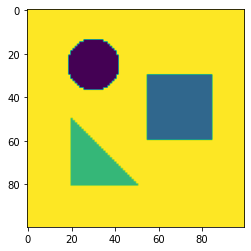

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from queue import PriorityQueue

world1 = np.loadtxt("worlds/world1.txt")
world2 = np.loadtxt("worlds/world2.txt")
world3 = np.loadtxt("worlds/world3.txt")
world4 = np.loadtxt("worlds/world4.txt")
print("This is an example environment:")
plt.imshow(world4)

def plot_GVD(grid, GVD, path=None):
    fig, ax = plt.subplots()
    GVD_grid = np.copy(grid)
    GVD_x, GVD_y = zip(*GVD)
    GVD_grid[GVD_x,GVD_y] = 20

    img1 = ax.imshow(GVD_grid, cmap="RdBu", alpha=0.6)
    obstacles = GVD_grid.copy()
    obstacles[obstacles < 0] = -2.0
    masked_data = np.ma.masked_where(obstacles > 0, obstacles)
    img2 = ax.imshow(masked_data, cmap="bwr")
    legend_elements = [Patch(facecolor='blue', label='Obstacle'),
                     Patch(facecolor='#83b1d3', label='GVD')]
    if path:
        path_x, path_y = zip(*path)
        GVD_grid[path_x,path_y] = 40.0
        grid_path = GVD_grid.copy()
        grid_path = np.ma.masked_where(grid_path != 40.0, grid_path)
        img3 = ax.imshow(grid_path, cmap="cool_r", interpolation="nearest") 
        legend_elements.append(Patch(facecolor='#e741f6', label='path'))

    ax.legend(handles=legend_elements)
    plt.show()

# Part One

Here, I set up the backbone of the algorithm. Specifically, these functions initialize all grid cells in terms of the brushfire algorithm. They then construct the GVD of the grid, which acts like a road map for the pathfinding algorithm

In [19]:
def initialize_brushfire_open_list_2(world):
    open_list = []
    GVD = []
    new_world = np.copy(world)
    new_world_backptrs = np.copy(world)
    new_world_backptrs = abs(new_world_backptrs)
    for i in range(len(new_world)):
        for j in range(len(new_world[i])):
            if i == 0 or i == len(new_world)-1 or j == 0 or j == len(new_world[i])-1 or is_boundary_cell(new_world, i, j):
                new_world[i,j] = 1
                backptr = get_cell_backptr(new_world, i, j)
                new_world_backptrs[i,j] = backptr
                open_list.append((i,j))
                GVD = update_GVD_neighbors(new_world_backptrs, GVD, backptr, i, j)
                
    return new_world, new_world_backptrs, GVD, open_list

def is_boundary_cell(new_world, i, j):
    if new_world[i,j] < 0:
        return False
    if new_world[i-1,j-1] < 0 or new_world[i-1,j] < 0 or new_world[i-1, j+1] < 0:
        return True
    elif new_world[i,j-1] < 0 or new_world[i, j+1] < 0:
        return True
    elif new_world[i+1,j-1] < 0 or new_world[i+1, j] < 0 or new_world[i+1,j+1] < 0:
        return True
    else:
        return False

def get_cell_backptr(new_world, i, j):
    backptr = is_adj_to_cspace_ends(new_world, i, j)
    if backptr != 0:
        return backptr
    backptr = is_adj_to_obs_boundary(new_world, i, j)
    if backptr != 0:
        return backptr
    else:
        return 0
    
def is_adj_to_cspace_ends(new_world, i, j):
    if i == 0:
        return -1 #first row
    elif j == len(new_world[i])-1:
        return -2 #last col
    elif i == len(new_world)-1:
        return -3 #last row
    elif j == 0:
        return -4 #first col
    else:
        return 0

def is_adj_to_obs_boundary(new_world, row, col):
    i = row-1
    while i <= row+1 and i < len(new_world):
        j = col-1
        while j <= col+1 and j < len(new_world[i]):
            if i == row and j == col:
                j+= 1
                continue
            elif new_world[i,j] < 0: #return the obstacle that its adjacent 
                return new_world[i,j] - 4
            j += 1
        i += 1
    return 0 

def update_GVD_neighbors(new_world_backptrs, GVD, backptr, row, col):
    i = row-1
    while i <= row+1 and i < len(new_world_backptrs):
        if i == -1:
            i += 1
            continue
        j = col-1
        while j <= col+1 and j < len(new_world_backptrs[0]):
            if j == -1 or (i == row and j == col):
                j += 1
                continue
            #if the adj obstacle has already been filled by a different backptr
            elif new_world_backptrs[i][j] < 0 and abs(new_world_backptrs[i][j]) != abs(backptr): 
                GVD.append((i,j))
                new_world_backptrs[i][j] = abs(new_world_backptrs[i][j])
            j += 1
        i += 1
    return GVD

In [20]:
def brushfire_and_GVD(new_world, new_world_backptrs, GVD, open_list):
    dist_to_obs = 2
    next_open_list = []
    while dist_to_obs == 2 or len(next_open_list) > 0:
        next_open_list.clear()
        while len(open_list) > 0:
            curr_cell = open_list.pop(0)
            backptr = new_world_backptrs[curr_cell[0]][curr_cell[1]]
            adj_free_cells, GVD = get_free_and_GVD_cells(new_world, new_world_backptrs, GVD, dist_to_obs, backptr, curr_cell[0], curr_cell[1])
            
            for cell in adj_free_cells:
                new_world[cell[0], cell[1]] = dist_to_obs
                next_open_list.append(cell)

        open_list = next_open_list.copy()
        dist_to_obs += 1

    return new_world, GVD, new_world_backptrs
            
#returns a list of cells 
def get_free_and_GVD_cells(new_world, new_world_backptrs, GVD, dist_to_obs, backptr, row, col):
    i = row-1
    output = []
    while i <= row+1 and i < len(new_world):
        if i == -1:
            i += 1
            continue
        j = col-1
        while j <= col+1 and j < len(new_world[i]):
            if j == -1 or (i == row and j == col):
                j += 1
                continue
            elif new_world[i,j] == 0:
                output.append((i,j))
                new_world_backptrs[i][j] = abs(backptr) * -1
            #if same iteration (marked cell), has already been filled in, and coming from different boundary, then add to gvd 
            elif (new_world[i,j] == new_world[row,col] or new_world[i,j] == dist_to_obs) and new_world_backptrs[i,j] < 0 and abs(new_world_backptrs[i,j]) != abs(backptr):
                new_world_backptrs[i][j] = abs(new_world_backptrs[i][j])                
                GVD.append((i,j))
            j += 1
        i += 1
    return output, GVD

# Part Two

This part of my implementation utilizes A-Star search to find a path along the road map between two points. For points that are off the road map, the algorithm then switches to using gradient ascent along the discretized grid points.

In [21]:
def a_star(new_world_backptrs, GVD, GVD_start, GVD_goal):
    open_list = PriorityQueue()
    open_list.put((0, GVD_start))
    came_from = {}
    g_score = {}
    h_score = {}
    for cell in GVD:
        g_score[cell] = float('inf')
        h_score[cell] = float('inf')
    g_score[GVD_start] = 0
    h_score[GVD_start] = calc_dist(GVD_start, GVD_goal)
    expanded_nodes = []
    
    while not open_list.empty():
        curr = open_list.get()[1]
        expanded_nodes.append(curr)
        if curr[0] == GVD_goal[0] and curr[1] == GVD_goal[1]:
            return create_path(came_from, curr)
        
        neighbors = expand_cell(new_world_backptrs, GVD, curr)
        for neighbor in neighbors:
            temp_g_score = g_score[curr] + calc_dist(curr, neighbor)
            if temp_g_score < g_score[neighbor]:
                came_from[neighbor] = curr
                g_score[neighbor] = temp_g_score
                h_score[neighbor] = g_score[neighbor] + calc_dist(neighbor, GVD_goal)
                open_list.put((h_score[neighbor], neighbor))
    return expanded_nodes
                    
def create_path(came_from, curr):
    the_path = [curr]
    while curr in came_from.keys():
        curr = came_from[curr]
        the_path.insert(0, curr)
    return the_path
    
def calc_dist(curr, goal):
    return np.sqrt( ((curr[0]-goal[0])**2)+((curr[1]-goal[1])**2) )
    
def expand_cell(new_world_backptrs, GVD, curr):
    i = curr[0]-1
    neighbors = []
    while i <= curr[0]+1 and i < len(new_world_backptrs):
        if i == -1:
            i += 1
            continue
        j = curr[1]-1
        while j <= curr[1]+1 and j < len(new_world_backptrs[i]):
            if j == -1 or (i == curr[0] and j == curr[1]) or (i,j) not in GVD: #if not in GVD
                j += 1
                continue
            neighbors.append((i,j))
            j += 1
        i += 1
    return neighbors
    
def path_to_GVD(new_world, new_world_backptrs, start_cell):
    path = []
    path.append(start_cell)
    curr = (start_cell[0], start_cell[1])
    while new_world_backptrs[curr[0],curr[1]] < 0: #checks if on the GVD or not
        next_cell = gradient_ascent(new_world, curr)
        path.append(next_cell)
        curr = (next_cell[0], next_cell[1])
    return path
        
def gradient_ascent(new_world, curr):
    i = curr[0]-1
    dist_to_obs = new_world[curr[0], curr[1]]
    while i <= curr[0]+1 and i < len(new_world):
        if i == -1:
            i += 1
            continue
        j = curr[1]-1
        while j <= curr[1]+1 and j < len(new_world[i]):
            if j == -1 or (i == curr[0] and j == curr[1]):
                j += 1
                continue
            if new_world[i,j] > dist_to_obs:
                return (i,j)
            j += 1
        i += 1
    return (curr[0]-1, curr[1]) #head north\

In [22]:
def compute_start_to_goal(new_world, new_world_backptrs, GVD, start, goal):
    start_to_GVD = path_to_GVD(new_world, new_world_backptrs, start)
    GVD_to_goal = path_to_GVD(new_world, new_world_backptrs, goal)[::-1]
    GVD_path = a_star(new_world_backptrs, GVD, start_to_GVD[len(start_to_GVD)-1], GVD_to_goal[0])
    
    result_path = start_to_GVD.copy()
    for cell in GVD_path:
        result_path.append(cell)
    for cell in GVD_to_goal:
        result_path.append(cell)
    return result_path

# Results
Here are some example outputs!

world1.txt. Start: (3,10); End: (80,90)


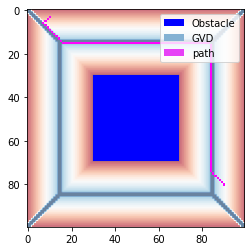

world2.txt. Start: (35,90); End: (80,5)


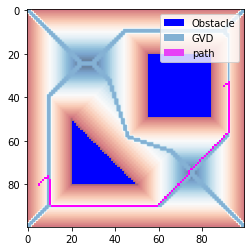

world3.txt. Start: (80,87); End: (2,20)


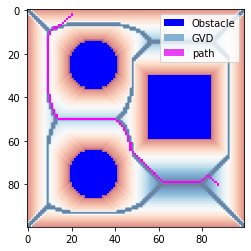

world4.txt. Start: (5,98); End: (80,5)


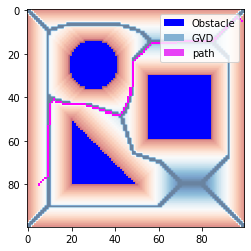

In [23]:
print("world1.txt. Start: (3,10); End: (80,90)")
path1 = compute_start_to_goal(new_world1, new_world_backptrs1, GVD1, (3,10), (80, 90))
plot_GVD(new_world1, GVD1, path1)

print("world2.txt. Start: (35,90); End: (80,5)")
path2 = compute_start_to_goal(new_world2, new_world_backptrs2, GVD2, (35,90), (80, 5))
plot_GVD(new_world2, GVD2, path2)

print("world3.txt. Start: (80,87); End: (2,20)")
path3 = compute_start_to_goal(new_world3, new_world_backptrs3, GVD3, (80,87), (2, 20))
plot_GVD(new_world3, GVD3, path3)

print("world4.txt. Start: (5,98); End: (80,5)")
path4 = compute_start_to_goal(new_world4, new_world_backptrs4, GVD4, (5,98), (80, 5))
plot_GVD(new_world4, GVD4, path4)